In [1]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

In [2]:
# Import libraries
import os
import json
from PIL import Image
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import tifffile as tiff
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torch import nn
import albumentations as album

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Exploration and Visualization

In [3]:
# Paths to data
DATA_PATH = os.path.join('/kaggle/input/hubmap-hacking-the-human-vasculature', 'train/')
POLYGONS_PATH = os.path.join('/kaggle/input/hubmap-hacking-the-human-vasculature', 'polygons.jsonl')
WSI_META_PATH = os.path.join('/kaggle/input/hubmap-hacking-the-human-vasculature', 'wsi_,eta.csv')
TILE_META_PATH = os.path.join('/kaggle/input/hubmap-hacking-the-human-vasculature', 'tile_meta.csv')

ff99cdef0f2a


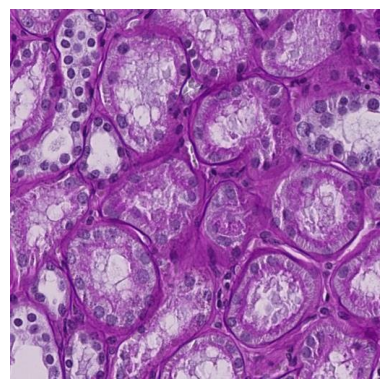

In [4]:
# Visualization of an image

# Path to your image file
image_path = os.path.join(DATA_PATH, os.listdir(DATA_PATH)[145])
image_id = os.listdir(DATA_PATH)[145]
print(image_id.split('.')[0])

# Load the image using matplotlib.image.imread
image = mpimg.imread(image_path)

# Display the image using matplotlib.pyplot.imshow
plt.imshow(image)
plt.axis('off')  # Optional: turn off axis ticks and labels
plt.show()

In [5]:
# Read jsonl file and creat a list of dicts
with open(POLYGONS_PATH, "r") as json_file:
    json_list = list(json_file)

tiles_dicts = []
for json_elem in json_list:
    tiles_dicts.append(json.loads(json_elem))

In [6]:
# Read tile meta csv
# tile meta csv contains metadata of each image
tile_meta_df = pd.read_csv(TILE_META_PATH)
tile_meta_df

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008
...,...,...,...,...,...
7028,ffd37b5c6598,13,3,13824,21504
7029,ffd3d193c71e,3,2,7680,16896
7030,ffd77e2517af,13,3,15872,28160
7031,ffe3cbb81f72,10,3,15456,23000


In [7]:
# Plot the annotation masks over the image
def get_cartesian_coords(coords, img_height):
    coords_array = np.array(coords).squeeze()
    xs = coords_array[:, 0]
    ys = -coords_array[:, 1] + img_height
    
    return xs, ys


def plot_annotated_image(image_dict, scale_factor: int = 1.0) -> None:
    #array = tiff.imread(CFG.img_path_template.format(image_dict["id"]))
    array = tiff.imread(f'/kaggle/input/hubmap-hacking-the-human-vasculature/train/{image_dict["id"]}.tif')
    
    img_example = Image.fromarray(array)
    annotations = image_dict["annotations"]
    
    # create figure
    fig = go.Figure()

    # constants
    img_width = img_example.size[0]
    img_height = img_example.size[1]
    
    # add invisible scatter trace
    fig.add_trace(
        go.Scatter(
            x=[0, img_width],
            y=[0, img_height],
            mode="markers",
            marker_opacity=0
        )
    )

    # configure axes
    fig.update_xaxes(
        visible=False,
        range=[0, img_width]
    )

    fig.update_yaxes(
        visible=False,
        range=[0, img_height],
        # the scaleanchor attribute ensures that the aspect ratio stays constant
        scaleanchor="x"
    )

    # add image
    fig.add_layout_image(dict(
        x=0,
        sizex=img_width,
        y=img_height,
        sizey=img_height,
        xref="x", yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_example
    ))
    
    # add polygons
    for annotation in annotations:
        name = annotation["type"]
        xs, ys = get_cartesian_coords(annotation["coordinates"], img_height)
        fig.add_trace(go.Scatter(
            x=xs, y=ys, fill="toself",
            name=name,
            hovertemplate="%{name}",
            mode='lines'
        ))

    # configure other layout
    fig.update_layout(
        width=img_width * scale_factor,
        height=img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        showlegend=False
    )

    # disable the autosize on double click because it adds unwanted margins around the image
    # and finally show figure
    fig.show(config={'doubleClick': 'reset'})

In [8]:
plot_annotated_image(tiles_dicts[8])

# Dataset Creation

In [9]:
# Create masks of blood vessels
def make_seg_mask(tiles_dict):
    mask = np.zeros((512, 512), dtype=np.float32)
    for annot in tiles_dict['annotations']:
        cords = annot['coordinates']
        if annot['type'] == "blood_vessel":
            for cd in cords:
                rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
                mask[rr, cc] = 1
                
    contours,_ = cv2.findContours((mask*255).astype(np.uint8), 1, 2)
    zero_img = np.zeros([mask.shape[0], mask.shape[1], 3], dtype="uint8")

    for p in contours:
        cv2.fillPoly(zero_img, [p], (255, 255, 255))

    contours, hierarchy = cv2.findContours(mask.astype("uint8"), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    img_with_area = zero_img

    for i in range(len(contours)):
        cv2.fillPoly(img_with_area, [contours[i][:,0,:]], (255-4*(i+1),255-4*(i+1),255-4*(i+1)), lineType=cv2.LINE_8, shift=0)
            
    return img_with_area  

In [10]:
# Save iamges and masks of blood vessels in a new directory
os.makedirs('train/image', exist_ok=True)
os.makedirs('train/mask', exist_ok=True)
os.makedirs('test/image', exist_ok=True)
os.makedirs('test/mask', exist_ok=True)

for i, tldc in enumerate(tqdm(tiles_dicts)):
    tile_id = tldc["id"]
    # Find the corresponding row in the DataFrame where 'id' matches the filename
    row = tile_meta_df[tile_meta_df['id'] == tile_id]
    # Check the 'dataset' value for the found row
    dataset_value = row['dataset'].values[0]
    array = tiff.imread(f'/kaggle/input/hubmap-hacking-the-human-vasculature/train/{tldc["id"]}.tif')
    img_example = Image.fromarray(array)
    img = np.array(img_example)
    mask = make_seg_mask(tldc)
    
    if np.sum(mask)>0:
        
        if dataset_value == 1:

            cv2.imwrite(f'test/image/{tldc["id"]}.png', img)
            cv2.imwrite(f'test/mask/{tldc["id"]}_mask.png', mask)
            
        else:
            
            cv2.imwrite(f'train/image/{tldc["id"]}.png', img)
            cv2.imwrite(f'train/mask/{tldc["id"]}_mask.png', mask)

100%|██████████| 1633/1633 [01:20<00:00, 20.22it/s]


In [11]:
# Define new paths to data
MYDATA_PATH = '/kaggle/working'
TRAIN_IMG_PATH = os.path.join(MYDATA_PATH, 'train/image')
TRAIN_MASK_PATH =  os.path.join(MYDATA_PATH, 'train/mask')
TEST_IMG_PATH = os.path.join(MYDATA_PATH, 'test/image')
TEST_MASK_PATH =  os.path.join(MYDATA_PATH, 'test/mask')

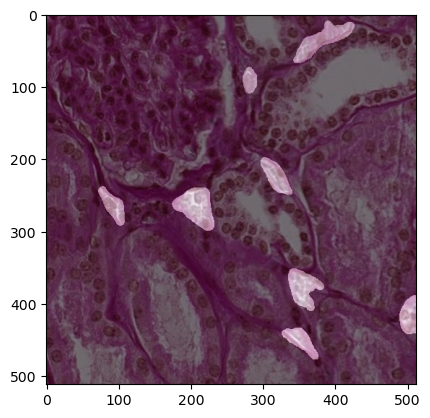

In [12]:
# Load an image using matplotlib.image.imread
image_path = os.path.join(TRAIN_IMG_PATH, '0006ff2aa7cd.png')
image = mpimg.imread(image_path)

mask_path =  os.path.join(TRAIN_MASK_PATH,'0006ff2aa7cd_mask.png')
mask = mpimg.imread(mask_path)

# Display the image using matplotlib.pyplot.imshow
plt.imshow(image)
plt.imshow(mask, alpha=0.5, cmap='jet')
plt.show()

In [13]:
# Create dataset
class HubMapDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir

        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_filenames)

        
    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        mask_name = self.mask_filenames[idx]

        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Open image and mask using PIL (Python Imaging Library)
        image = Image.open(image_path).convert("RGB")
        if self.img_transform:
            image = self.img_transform(image)
        
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [14]:
from segmentation_models_pytorch import utils

In [15]:
# Config class
class CFG:
    
    batch_size_train = 8
    batch_size_val = 1
    size = 512
    org_size = 512
    # encoder_depth = 4
    # decoder_channels = [512, 256, 128, 64]
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(device)
    use_cuda = torch.cuda.is_available()
    if use_cuda:
      torch.cuda.manual_seed(1)
    
    # Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
    TRAINING = True
    
    # Set num of epochs
    EPOCHS = 12
    # define loss function
    loss = smp.utils.losses.DiceLoss()

    # define metrics
    metrics = [
        smp.utils.metrics.IoU(threshold=0.5),
    ]


    
    # Image transformations
    image_transform = transforms.Compose([
        transforms.Resize((size, size)),  # Resize the image to the desired size
        transforms.ToTensor(), # Convert PIL image to PyTorch tensor
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize image
    ])

    # Mask transformations (no normalization applied)
    mask_transform = transforms.Compose([
        transforms.Resize((size, size)),  # Resize the mask to the desired size
        transforms.ToTensor(), # Convert PIL image to PyTorch tensor
    ])
    
    

cuda


In [16]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [17]:
# Create Datasets
train_dataset = HubMapDataset(
    image_dir=TRAIN_IMG_PATH, 
    mask_dir=TRAIN_MASK_PATH, 
    img_transform=CFG.image_transform, 
    mask_transform=CFG.mask_transform
)

test_dataset = HubMapDataset(
    image_dir=TEST_IMG_PATH, 
    mask_dir=TEST_MASK_PATH, 
    img_transform=CFG.image_transform, 
    mask_transform=CFG.mask_transform
)

# Create train validation split
train_dataset, val_dataset = random_split(train_dataset, [0.6, 0.4])

print(f'Train split length: {len(train_dataset)}')
print(f'Val split length: {len(val_dataset)}')
print(f'Test split length: {len(test_dataset)}')


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size_train, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size_val, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size_val, shuffle=False)


Train split length: 724
Val split length: 482
Test split length: 416


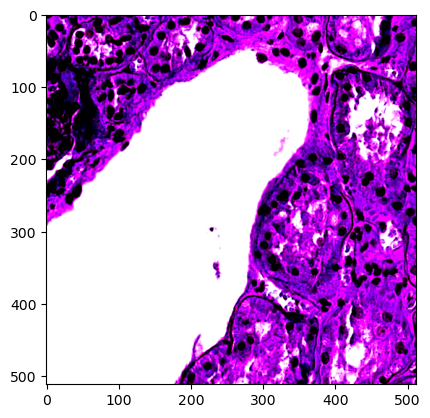

In [18]:
# Helper function to get a random image-mask pair from a dataset
def get_random_sample(dataset):
    idx = torch.randint(0, len(dataset), (1,))
    return dataset[idx]

# Get random samples from each dataset
train_sample_image, train_sample_mask = get_random_sample(train_dataset)
val_sample_image, val_sample_mask = get_random_sample(val_dataset)
test_sample_image, test_sample_mask = get_random_sample(test_dataset)

plt.imshow(train_sample_image.permute(1, 2, 0))
plt.show()

# Model Implementation

In [19]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x
    

# Get UNet model
model = UNet()

In [20]:
# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

In [21]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=CFG.loss, 
    metrics=CFG.metrics, 
    optimizer=optimizer,
    device=CFG.device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=CFG.loss, 
    metrics=CFG.metrics, 
    device=CFG.device,
    verbose=True,
)

# Model Training and Evaluation

In [22]:
if CFG.TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, CFG.EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(val_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)


Epoch: 0
valid: 100%|██████████| 482/482 [00:32<00:00, 14.71it/s, dice_loss - 0.9421, iou_score - 0.02769]

Epoch: 1
valid: 100%|██████████| 482/482 [00:32<00:00, 14.86it/s, dice_loss - 0.9502, iou_score - 0.02737]

Epoch: 2
valid: 100%|██████████| 482/482 [00:32<00:00, 14.70it/s, dice_loss - 0.9698, iou_score - 0.01957]

Epoch: 3
valid: 100%|██████████| 482/482 [00:32<00:00, 14.98it/s, dice_loss - 0.959, iou_score - 0.01967]

Epoch: 4
valid: 100%|██████████| 482/482 [00:32<00:00, 14.76it/s, dice_loss - 0.9386, iou_score - 0.01979]

Epoch: 5
valid: 100%|██████████| 482/482 [00:32<00:00, 14.66it/s, dice_loss - 0.9395, iou_score - 0.009992]

Epoch: 6
valid: 100%|██████████| 482/482 [00:33<00:00, 14.44it/s, dice_loss - 0.9978, iou_score - 0.008523]

Epoch: 7
valid: 100%|██████████| 482/482 [00:33<00:00, 14.58it/s, dice_loss - 0.9958, iou_score - 0.00852]

Epoch: 8
valid: 100%|██████████| 482/482 [00:32<00:00, 14.80it/s, dice_loss - 0.992, iou_score - 0.008516]

Epoch: 9
valid: 100%|█████

In [23]:
# Evaluation on test data
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=CFG.loss, 
    metrics=CFG.metrics, 
    device=CFG.device,
    verbose=True,
)

valid_logs = test_epoch.run(test_loader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")


valid: 100%|██████████| 416/416 [00:27<00:00, 14.90it/s, dice_loss - 0.861, iou_score - 0.0111]
Evaluation on Test Data: 
Mean IoU Score: 0.0111
Mean Dice Loss: 0.8610


In [24]:
# Plot Dice Loss & IoU Metric for Train vs. Val
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T


,0,1,2,3,4,5,6,7,8,9,10,11
dice_loss,-15.026504,1.830844,4.038220,0.739435,0.781056,1.969206,0.881957,0.882107,0.882017,0.881918,0.88181,0.881692
iou_score,0.029465,0.039484,0.038483,0.024924,0.025479,0.021758,0.010286,0.010298,0.010292,0.010287,0.01028,0.010275


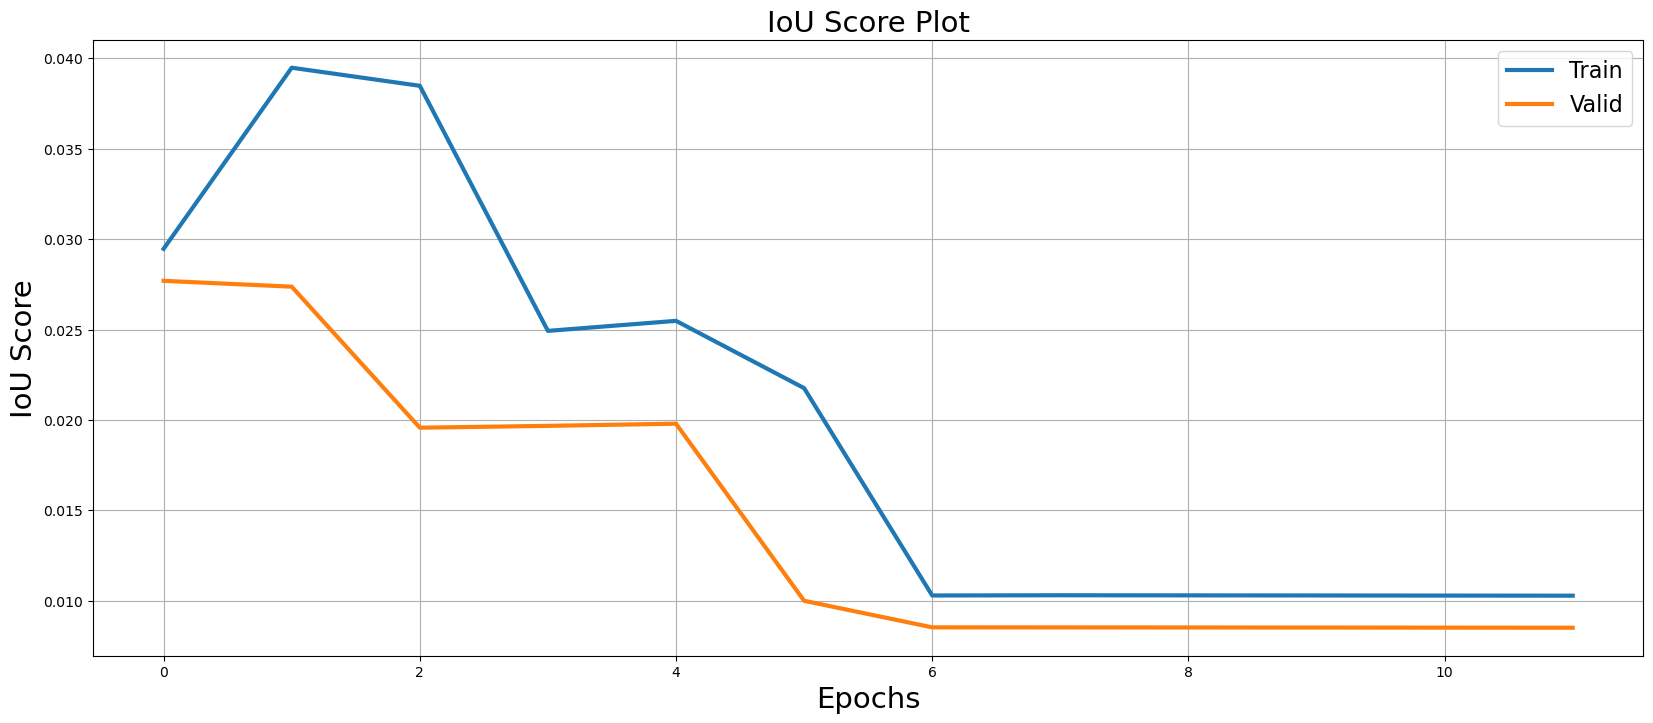

In [25]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

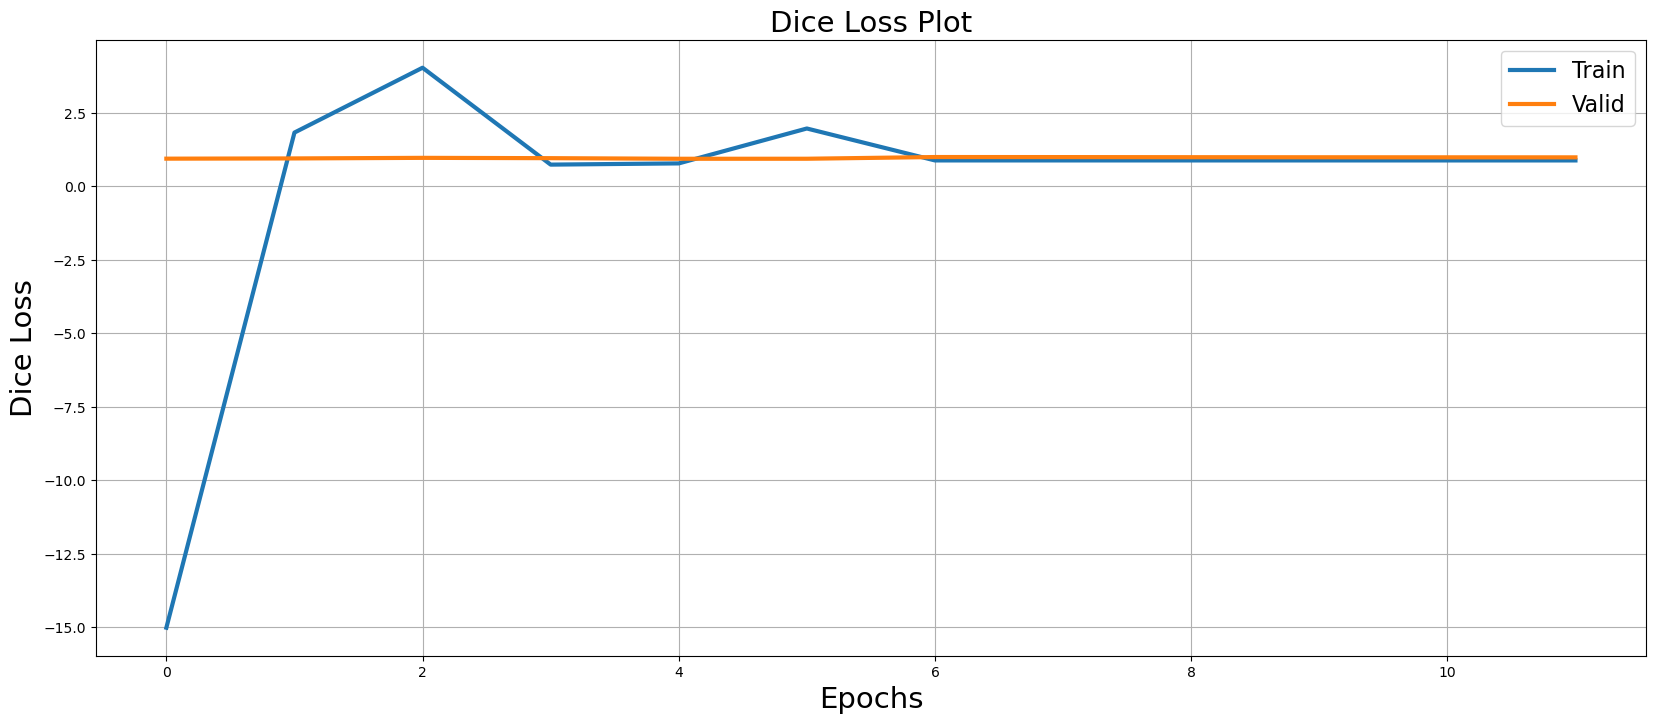

In [26]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()